In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

sys.path.insert(0, '../../')

In [2]:
import src.utils.imports as im
import src.utils.functions as fn
from datetime import datetime
import imblearn
import pickle
%matplotlib inline

## Data Preporation

In [3]:
# Set path to directory with folders train and test

df = im.pd.read_csv('../../data/train.csv')
path_train = '../../datasets/train_wav/'
path_train_noised = '../../datasets/train_wavs_noised_002/'

In [5]:
# takes roughly 10-15 minutes
# x_data_hc, y_data_hc = fn.create_HC_dataset_wavs(df, path_train, Noised=False)

In [11]:
# im.np.save("x_data_hc", x_data_hc)
# im.np.save("y_data_hc", y_data_hc)

x_data_hc = im.np.load("x_data_hc.npy")
y_data_hc = im.np.load("y_data_hc.npy")

In [6]:
x_data_hc_augmented, y_data_hc_augmented = fn.augment_data(x_data_hc, y_data_hc, augmentation_factor=12000)

In [7]:
x_train_val, x_test_hc, y_train_val, y_test_hc = im.train_test_split(x_data_hc_augmented, y_data_hc_augmented, test_size=0.1, random_state=42, shuffle=True, stratify=y_data_hc_augmented)

In [8]:
x_train_hc, x_val_hc, y_train_hc, y_val_hc = im.train_test_split(x_train_val, y_train_val, test_size=0.1, random_state=42, shuffle=True, stratify=y_train_val)

In [10]:
train_data_hc = im.tf.data.Dataset.from_tensor_slices((x_train_hc, y_train_hc))
val_data_hc = im.tf.data.Dataset.from_tensor_slices((x_val_hc, y_val_hc))
test_data_hc = im.tf.data.Dataset.from_tensor_slices((x_test_hc, y_test_hc))

batch_size = 64

train_data_hc = train_data_hc.batch(batch_size)
val_data_hc = val_data_hc.batch(batch_size)
test_data_hc = test_data_hc.batch(batch_size)

## Inception Time Network

In [11]:
def inception_module(x, filters):
    branches = []
    
    # 1x1 convolution branch
    branch1 = im.Conv1D(filters=filters[0], kernel_size=1, activation='relu')(x)
    drop1 = im.Dropout(0.2)(branch1)
    branches.append(drop1)
    
    # 2x1 convolution branch
    branch2 = im.Conv1D(filters=filters[1], kernel_size=2, padding='same', activation='relu')(x)
    drop2 = im.Dropout(0.2)(branch2)
    branches.append(drop2)
    
    # 4x1 convolution branch
    branch4 = im.Conv1D(filters=filters[2], kernel_size=4, padding='same', activation='relu')(x)
    drop4 = im.Dropout(0.2)(branch4)
    branches.append(drop4)

    # this line makes residual network - if you need classic, just comment it
    branches.append(x)
    
    # Concatenate the outputs of all branches
    concatenated = im.keras.layers.concatenate(branches)
    
    return concatenated

In [12]:
def build_inception_time(input_shape, num_classes):
    inputs = im.Input(shape=input_shape)
    
    x = im.Conv1D(filters=128, kernel_size=1, activation='relu')(inputs)
    
    # Inception modules
    x = inception_module(x, [32, 64, 128])
    x = inception_module(x, [32, 64, 128])
    x = inception_module(x, [32, 64, 128])
    
    x = im.MaxPooling1D(pool_size=3, strides=2)(x)
    x = im.Flatten()(x)
    
    x = im.Dense(256, activation='relu')(x)
    drop = im.keras.layers.Dropout(0.1)(x)
    # x = im.Dense(num_classes, activation='softmax')(drop)
    x = im.Dense(1, activation='sigmoid')(drop)
    
    model = im.Model(inputs=inputs, outputs=x)
    return model

In [13]:
# Define input shape and number of classes
input_shape = x_train_hc.shape[1:]
num_classes = 2

# Build the Inception-Time model
model = build_inception_time(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', fn.f1_score, fn.recall, fn.precision])

In [14]:
# Print model

# model_img_file = '../../images/inception_model.png'
# im.tf.keras.utils.plot_model(model, to_file=model_img_file, 
#                             show_shapes=True, 
#                             show_layer_activations=True, 
#                             show_dtype=True,
#                             show_layer_names=False)

In [14]:
# Learning Rate Schedule for Fine Tuning 
def exponential_lr(epoch,
                   start_lr = 0.001, min_lr = 0.00001, max_lr = 0.005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.85):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

In [15]:
epochs = 70
weights_inception = "../weights_inception/InceptionTime.h5"

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = im.keras.callbacks.TensorBoard(log_dir=logdir)

callbacks = [
    im.keras.callbacks.ModelCheckpoint(
        weights_inception, save_best_only=True, monitor="val_loss"
    ),
    # im.keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20, mode='min', min_lr=0
    # ),
    im.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True),
    im.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, restore_best_weights=True),
    im.keras.callbacks.TensorBoard(log_dir=logdir),
]

In [16]:
HistoryInception = model.fit(
    train_data_hc,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_data_hc,
    verbose=1,
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/70
532/532 [==============================] - 7s 13ms/step - loss: 0.1271 - accuracy: 0.8120 - f1_score: 0.6007 - recall: 0.4442 - precision: 0.9887 - val_loss: 0.0985 - val_accuracy: 0.8442 - val_f1_score: 0.6598 - val_recall: 0.4953 - val_precision: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001800000037997961.
Epoch 2/70
  9/532 [..............................] - ETA: 7s - loss: 0.1103 - accuracy: 0.8281 - f1_score: 0.5932 - recall: 0.4358 - precision: 1.0000

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


532/532 [==============================] - 8s 15ms/step - loss: 0.1012 - accuracy: 0.8434 - f1_score: 0.6347 - recall: 0.4715 - precision: 1.0000 - val_loss: 0.0915 - val_accuracy: 0.8622 - val_f1_score: 0.6500 - val_recall: 0.4844 - val_precision: 1.0000 - lr: 0.0018

Epoch 3: LearningRateScheduler setting learning rate to 0.0030800000512972475.
Epoch 3/70
532/532 [==============================] - 8s 16ms/step - loss: 0.1006 - accuracy: 0.8442 - f1_score: 0.6466 - recall: 0.4833 - precision: 1.0000 - val_loss: 0.0969 - val_accuracy: 0.8421 - val_f1_score: 0.6280 - val_recall: 0.4602 - val_precision: 1.0000 - lr: 0.0031

Epoch 4: LearningRateScheduler setting learning rate to 0.004231999974697828.
Epoch 4/70
532/532 [==============================] - 8s 16ms/step - loss: 0.0996 - accuracy: 0.8479 - f1_score: 0.6385 - recall: 0.4743 - precision: 1.0000 - val_loss: 0.0919 - val_accuracy: 0.8627 - val_f1_score: 0.6575 - val_recall: 0.4927 - val_precision: 1.0000 - lr: 0.0042

Epoch 5: Le

In [17]:
with open('HistoryInceptionDict', 'wb') as file_pi:
    pickle.dump(HistoryInception.history, file_pi)

In [18]:
with open('HistoryInceptionDict', "rb") as file_pi:
    HistoryInceptionFile = pickle.load(file_pi)

In [19]:
# model = im.keras.models.load_model(weights_inception)

test = model.evaluate(test_data_hc)
# test_loss, test_acc = model.evaluate(test_data_hc)

print("Test loss", test[0])
print("Test accuracy", test[1])
print("Test f1-score", test[2])
print("Test recall", test[3])
print("Test precision", test[4])

66/66 [==============================] - 0s 5ms/step - loss: 0.0891 - accuracy: 0.8595 - f1_score: 0.6522 - recall: 0.4871 - precision: 1.0000
Test loss 0.08908534049987793
Test accuracy 0.8595238327980042
Test f1-score 0.6522206664085388
Test recall 0.48712122440338135
Test precision 1.0


In [20]:
metric = "accuracy"

LossInception = HistoryInceptionFile["loss"]
ValLossInception = HistoryInceptionFile["val_loss"]

AccInception = HistoryInceptionFile[metric]
ValAccInception = HistoryInceptionFile["val_" + metric]

LrInception = HistoryInceptionFile["lr"]

EpochsInception = range(1, len(AccInception) + 1)

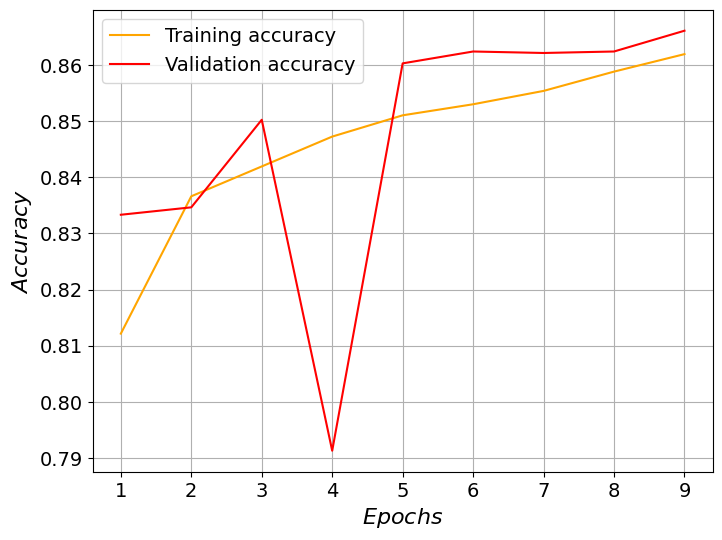

In [21]:
fn.PlotLossAcc(TrainData=AccInception, ValData=ValAccInception, Epochs=EpochsInception,
            TrainLabel='Training accuracy', ValLabel='Validation accuracy',
            yLabel=r'$Accuracy$', title=False,
            ColTrain='orange', ColVal='red', filename="../../images/acc_inceptiontime.pdf")

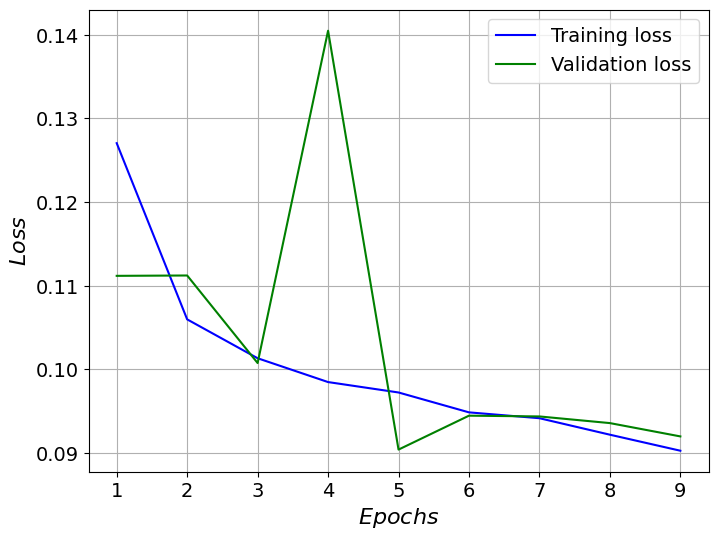

In [22]:
fn.PlotLossAcc(TrainData=LossInception, ValData=ValLossInception, Epochs=EpochsInception,
            TrainLabel='Training loss', ValLabel='Validation loss',
            yLabel=r'$Loss$', title=False,
            ColTrain='blue', ColVal='green', filename="../../images/loss_inceptiontime.pdf")

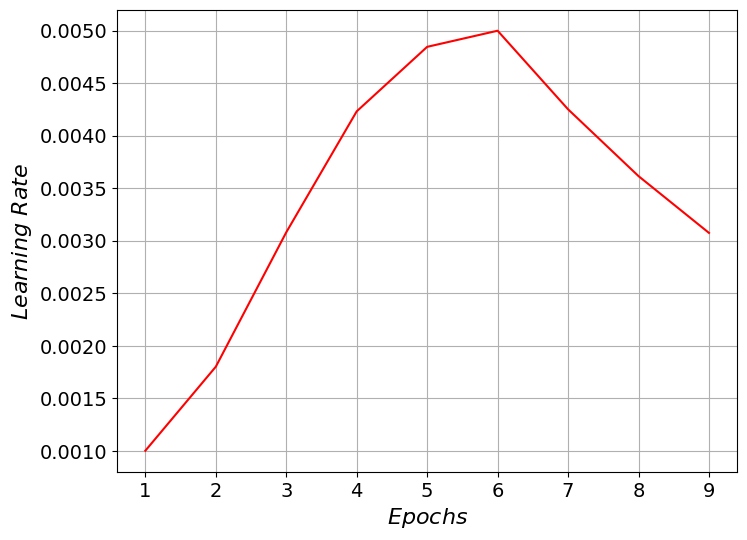

In [23]:
fn.PlotLossAcc(TrainData=LrInception, ValData=[], Epochs=EpochsInception,
            TrainLabel='', ValLabel='',
            yLabel=r'$Learning\ Rate$', title=False,
            ColTrain='red', ColVal='', filename="../../images/lr_inceptiontime.pdf", lr=True)

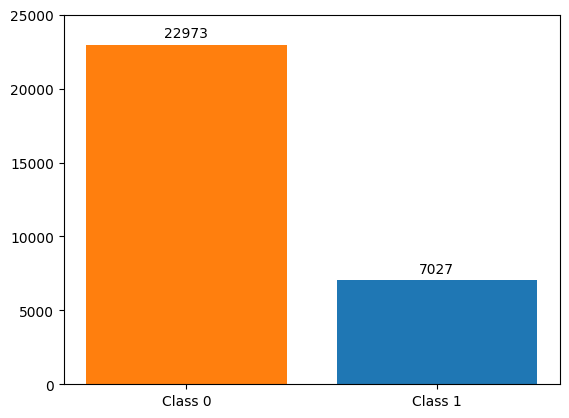

In [24]:
fn.PlotDataDistribution(samples=['Class 0', 'Class 1'], counts=[22973, 7027],
                        bar_labels=['Not Whale', 'Whale'], bar_colors=['tab:orange', 'tab:blue'],
                        filename="../../images/data_distribution.pdf", legend=False)